In [12]:
import config as cfg
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx

In [13]:
if cfg.type_of_study == 'month':
    file_name = 'all_viajes_month_0322.csv'
elif cfg.type_of_study == 'week':
    file_name = 'viajes_week_0322.csv'  #TODO: CORRECT IF NEEDED
elif cfg.type_of_study == 'two_weeks':
    file_name = 'viajes_two_weeks_0322.csv'  #TODO: CORRECT IF NEEDED
elif cfg.type_of_study == 'weekend':
    file_name = 'viajes_weekend_0322.csv'  #TODO: CORRECT IF NEEDED
else:
    file_name = 'default_file.csv'  # FIXME: Fallback option if neither is True


merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') 
distritos = pd.read_csv(cfg.ZONIFICACION_DATA / 'distritos/PROCESSED_nombres_distritos.csv')

all_viajes = pd.read_csv(cfg.MOBILITY_DATA / f'VIAJES/{file_name}', thousands='.', decimal=',') #df of interest
filtered_viajes = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')]
population = pd.read_csv('raw/poblacion_distritos_enero_21.csv', sep=';') # SOURCE: https://www.madrid.es/portales/munimadrid/es/Inicio/El-Ayuntamiento/Estadistica/?vgnextfmt=default&vgnextchannel=8156e39873674210VgnVCM1000000b205a0aRCRD

In [14]:
all_viajes

,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km
0,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,hombre,29337,30222
1,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,mujer,34143,27522
2,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,hombre,92799,63331
3,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,mujer,65475,44556
4,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,45-65,hombre,44319,31052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19900950,20220331,23,2807921,2807921,2-10,trabajo_estudio,frecuente,no,no,28,>15,0-25,hombre,6787,19129
19900951,20220331,23,2807921,2807921,2-10,trabajo_estudio,frecuente,no,no,28,>15,25-45,mujer,34,9053
19900952,20220331,23,2807921,2807921,2-10,trabajo_estudio,frecuente,no,no,28,>15,65-100,hombre,2005,4716
19900953,20220331,23,2807921,2807921,2-10,trabajo_estudio,no_frecuente,no,no,28,10-15,0-25,hombre,9134,33998


In [15]:
all_viajes.viajes.sum()

np.int64(17943676655588556)

In [16]:
filtered_viajes.viajes.sum()

np.int64(3298899374979997)

In [17]:
filtered_viajes.viajes.describe()

count    4.839108e+06
mean     6.817164e+08
std      1.886442e+10
min      1.000000e+01
25%      3.169000e+03
50%      6.642000e+03
75%      1.375200e+04
max      9.995744e+11
Name: viajes, dtype: float64

In [18]:
filtered_viajes.viajes_km.describe()

count    4.839108e+06
mean     6.901610e+08
std      1.949609e+10
min      1.000000e+01
25%      1.198100e+04
50%      2.948200e+04
75%      6.165300e+04
max      9.998626e+11
Name: viajes_km, dtype: float64

In [19]:
filtered_viajes.shape

(4839108, 15)

## Median Income Distribution

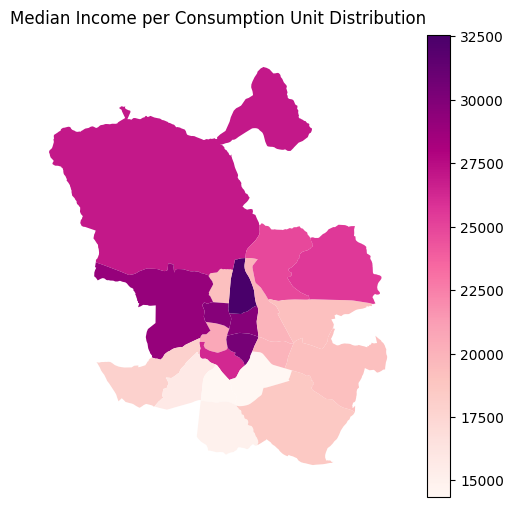

In [20]:
fig, ax = plt.subplots(1, figsize=(6, 6))
merged.plot(
        column='Median income per consumption unit',  # Column containing the LISA values
        cmap='RdPu',        # Use the RdPu colormap
        legend=True,            # Show legend
        ax=ax                   # Axis to plot on
    )
    
    # Set the title with global statistics
ax.set_title('Median Income per Consumption Unit Distribution'
    )

    # Remove axis labels
ax.set_axis_off()

## The City of Madrid

In [21]:
gdf_with_names = merged.merge(distritos[['ID', 'name_2']], on='ID')
gdf_with_names = gdf_with_names[['ID', 'geometry', 'name_2']]
gdf_with_names['ID'] = gdf_with_names['ID'].astype(str).str[-2:]
gdf_with_names = gdf_with_names.to_crs(epsg=3857)

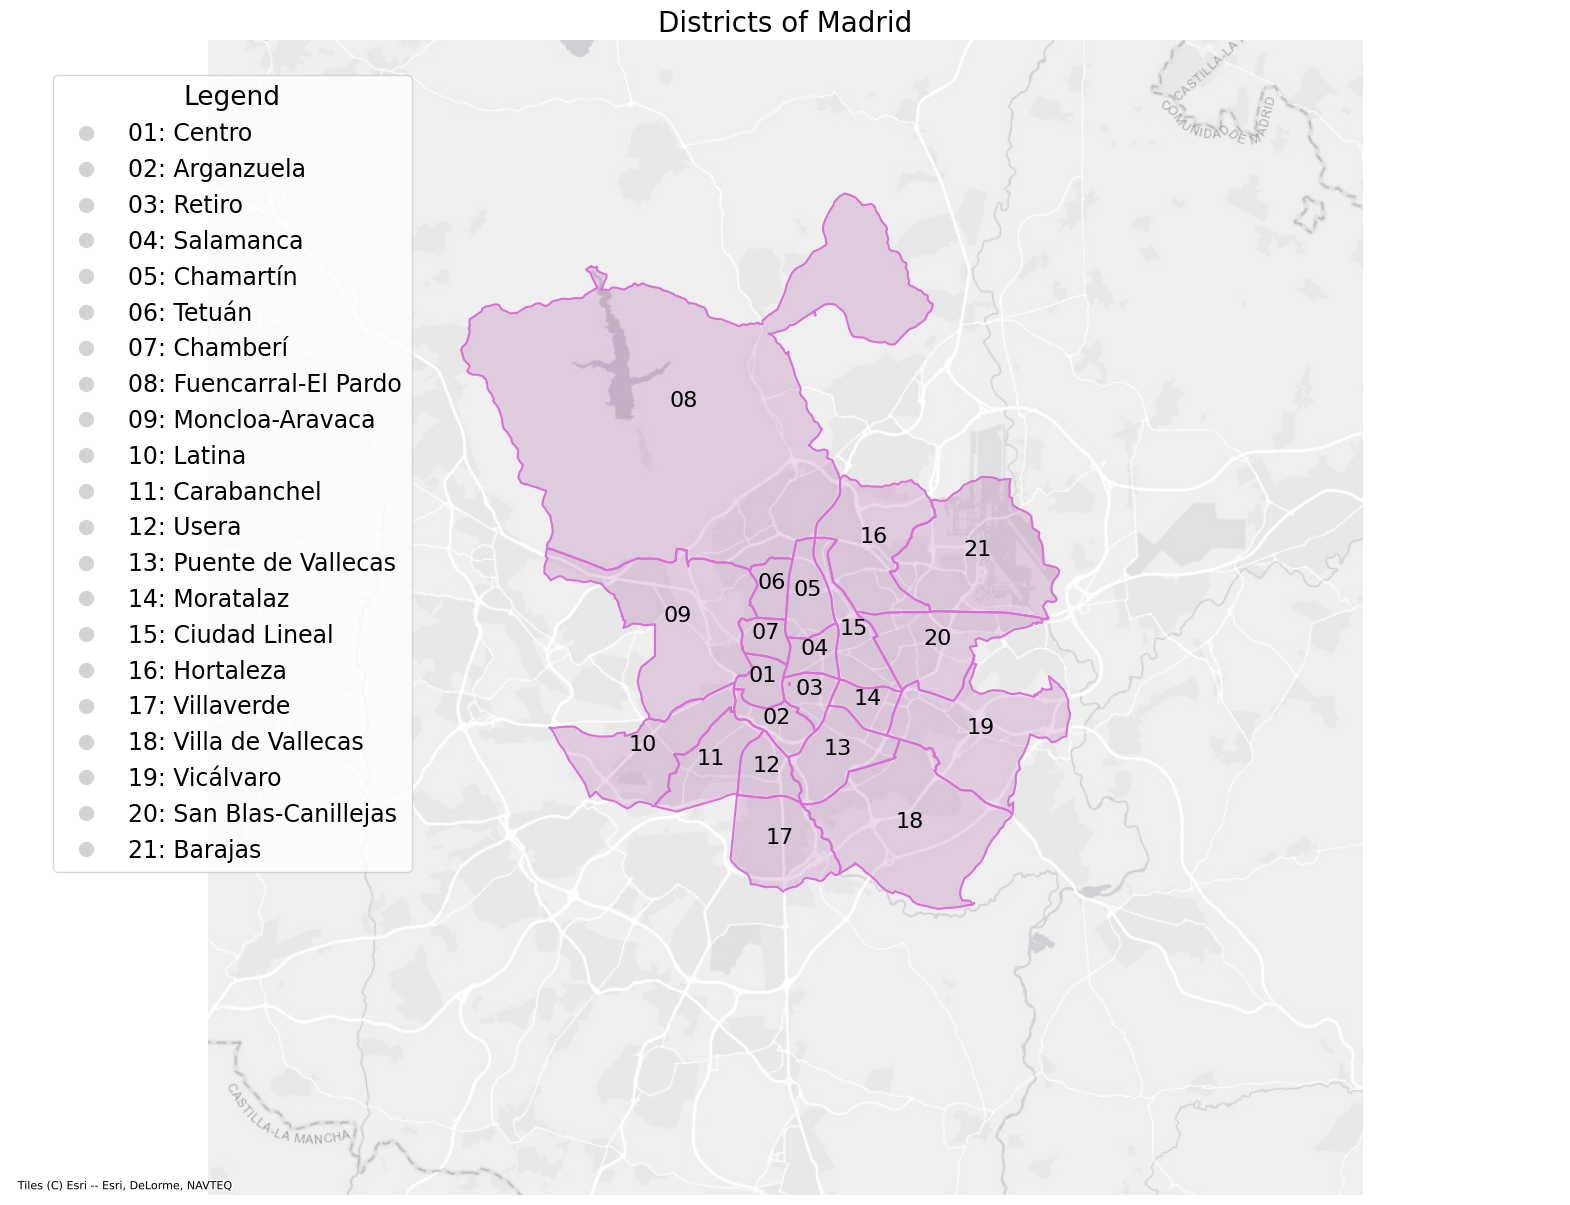

In [22]:
ax = gdf_with_names.plot(figsize=(20,15), color="purple", alpha=0.15)
gdf_with_names.boundary.plot(color="#DA70D6", ax=ax)

ctx.add_basemap(ax,
               crs=gdf_with_names.crs.to_string(),
               source=ctx.providers.Esri.WorldGrayCanvas
              )

bounds = gdf_with_names.total_bounds
ax.set_xlim(bounds[0], bounds[2])  # Set x-axis (longitude)
ax.set_ylim(bounds[1], bounds[3])  # Set y-axis (latitude)

texts = []

# Add district names as annotations
for x, y, label in zip(gdf_with_names.geometry.centroid.x, 
                       gdf_with_names.geometry.centroid.y, 
                       gdf_with_names['ID']):
    texts.append(ax.text(x, y, label, fontsize=16, ha='center', color='black'))  # Change color of text to red

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{num}: {name}",
                          markerfacecolor='lightgray', markersize=12)
                   for num, name in zip(gdf_with_names['ID'], gdf_with_names['name_2'])]

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98),  # Adjust position inside plot
          title='Legend', fontsize=17, title_fontsize=19, frameon=True)  # Larger font sizes and frame

# Remove axes
ax.set_axis_off()
ax.set_title('Districts of Madrid', fontsize=20)
plt.axis('equal')

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / 'districts_of_madrid.png', dpi=300, bbox_inches='tight')

## Distritos and Population

In [23]:
population = population.drop(columns=['Total.1'])
population.columns = ['ID', 'Population']
distritos['ID'] = distritos['ID'].astype(str)
population['ID'] = population['ID'].astype(str)

In [24]:
distritos_and_pop = pd.merge(distritos, population, left_index=True, right_index=True)
distritos_and_pop = distritos_and_pop.drop(columns=['ID_y'])
distritos_and_pop = distritos_and_pop.rename(columns={'ID_x': 'ID'})

In [25]:
distritos_and_pop

,ID,name,name_2,Population
0,2807901,Madrid distrito 01,Centro,142.099
1,2807902,Madrid distrito 02,Arganzuela,154.809
2,2807903,Madrid distrito 03,Retiro,119.006
3,2807904,Madrid distrito 04,Salamanca,146.698
4,2807905,Madrid distrito 05,Chamartín,146.230
5,2807906,Madrid distrito 06,Tetuán,160.390
6,2807907,Madrid distrito 07,Chamberí,139.167
7,2807908,Madrid distrito 08,Fuencarral-El Pardo,248.384
8,2807909,Madrid distrito 09,Moncloa-Aravaca,121.339
9,2807910,Madrid distrito 10,Latina,241.013


In [ ]:
if cfg.SAVE_DATASETS:
    distritos_and_pop.to_csv(cfg.DATASETS_PATH / 'districts_and_population.csv', index=False)

## Gini Index

In [ ]:
distritos_and_pop = pd.read_csv(cfg.DATASETS_PATH / 'districts_and_population.csv')
merged['ID'] = merged['ID'].astype(str)
distritos_and_pop['ID'] = distritos_and_pop['ID'].astype(str)
gini_and_districts = pd.merge(merged[['ID', 'Gini Index']], distritos_and_pop[['ID', 'name_2']], on='ID')

# Select the 'name_2' and 'Gini Index' columns
gini_and_districts = gini_and_districts[['name_2', 'Gini Index']]

gini_and_districts = gini_and_districts.rename(columns={'name_2': 'District'})

In [ ]:
if cfg.SAVE_DATASETS:
    gini_and_districts.to_csv(cfg.DATASETS_PATH / 'districts_and_gini.csv', index=False)

In [ ]:
gini_and_districts

## Global Moran's I

In [ ]:
df = pd.read_csv('/Users/caro/Desktop/thesis_project/segregation_indices/outputs/global_morans_i_df.csv')

variables = df['Variable']  # The income variables
morans_I = df['Global Morans I']  # The Global Moran's I values
p_values = df['P-value']  # The p-values

In [ ]:
df

In [ ]:
sns.set(font_scale=1.7) # TODO: Check this!

In [ ]:
colors = ['purple' if p < 0.05 else 'black' for p in p_values]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(morans_I, variables, color=colors, s=100,  marker='s')  # s sets the size of the dots

# Set labels and title
plt.xlabel('Global Moran\'s I', fontsize=12)
plt.title('Global Moran\'s I for Income Variables and Significance Levels', fontsize=14)
plt.xticks(fontsize=12)

# Customizing the y-axis labels (income variables)
plt.yticks(range(len(variables)), variables, fontsize=12)

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / 'global_morans_significance.png', dpi=300, bbox_inches='tight')

## Income data

In [ ]:
merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') 

In [ ]:
merged['Average income per consumption unit'].describe()

In [ ]:
income_stats = merged.describe()
income_stats_big = income_stats.drop(columns=['ID', 'Gini Index'])
income_stats_small = income_stats[['Gini Index']]
income_stats_big = income_stats_big.round(3)
income_stats_small = income_stats_small.round(3)

if cfg.SAVE_DATASETS:
    income_stats_big.to_csv(cfg.DATASETS_PATH / 'income_stats.csv', index=True)
    income_stats_small.to_csv(cfg.DATASETS_PATH / 'gini_stats.csv', index=True)

In [ ]:
income_stats_big

In [ ]:
income_stats_big = income_stats_big.drop(index='count')
income_stats_big = income_stats_big.reset_index().rename(columns={'index': 'Statistic'})

income_stats_small = income_stats_small.drop(index='count')
income_stats_small = income_stats_small.reset_index().rename(columns={'index': 'Statistic'})

In [ ]:
income_stats_big

In [ ]:
income_stats_big = income_stats_big.melt(id_vars='Statistic', var_name='Income Category', value_name='Value')

In [ ]:
# Plotting the violin plot
plt.figure(figsize=(12, 8))

sns.boxplot(x='Income Category', y='Value', data=income_stats_big, palette='Set3')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)  # Increase the font size of y-tick labels
plt.title('Distribution of Income Statistics', fontsize=16)  # Increase the font size of the title
plt.xlabel('Income Category', fontsize=15)  # Increase font size for x-axis label
plt.ylabel('Value', fontsize=15)  # Increase font size for y-axis label
plt.tight_layout()

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / 'income_statistics_boxplot.png', dpi=300, bbox_inches='tight')

## Trips and Normalized Trips

In [ ]:
all_viajes.shape

In [ ]:
filtered_viajes.shape

In [ ]:
normalized_trip_counts = pd.read_csv(f'/Users/caro/Desktop/thesis_project/trip_analysis/outputs/{cfg.type_of_study}_normalized_trip_count.csv')

In [ ]:
normalized_trip_counts

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

plt.figure(figsize=(10, 6))
sns.histplot(normalized_trip_counts['normalized_trip_count'], bins=50, kde=True, color='blue', alpha=0.7)
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

formatter = mticker.ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

plt.title('Distribution of Normalised Trip Counts')
plt.xlabel('Normalised Trip Count')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig(f'{cfg.FIGURES_PATH}/{cfg.type_of_study}_normalized_trip_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(normalized_trip_counts['trip_count'], bins=50, kde=True, color='blue', alpha=0.7)

ax = plt.gca()  # Get the current axis

# Set axis formatter to remove scientific notation
formatter = mticker.ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Set a reasonable number of x-axis bins
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

plt.xticks(rotation=90)

plt.title('Distribution of Total Trip Counts')
plt.xlabel('Total Trip Count')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig(f'{cfg.FIGURES_PATH}/{cfg.type_of_study}_unnormalized_trip_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Extra Descriptives

In [ ]:
df = pd.read_csv(f'/Users/caro/Desktop/thesis_project/trip_analysis/outputs/month_normalized_trip_count.csv')

In [ ]:
df.describe()

In [ ]:
df.tail()

In [6]:
origin_trips = filtered_viajes.groupby('origen')['viajes'].sum().reset_index(name='total_viajes') # FIXED

In [9]:
origin_trips

,origen,total_viajes
0,2807901,136712522521830
1,2807902,168422569542303
2,2807903,140204703470897
3,2807904,137807602115964
4,2807905,155758333501603
5,2807906,139590562531537
6,2807907,122276371681272
7,2807908,172106172640282
8,2807909,159416530936269
9,2807910,152988112059524


In [26]:
distritos_and_pop

,ID,name,name_2,Population
0,2807901,Madrid distrito 01,Centro,142.099
1,2807902,Madrid distrito 02,Arganzuela,154.809
2,2807903,Madrid distrito 03,Retiro,119.006
3,2807904,Madrid distrito 04,Salamanca,146.698
4,2807905,Madrid distrito 05,Chamartín,146.230
5,2807906,Madrid distrito 06,Tetuán,160.390
6,2807907,Madrid distrito 07,Chamberí,139.167
7,2807908,Madrid distrito 08,Fuencarral-El Pardo,248.384
8,2807909,Madrid distrito 09,Moncloa-Aravaca,121.339
9,2807910,Madrid distrito 10,Latina,241.013


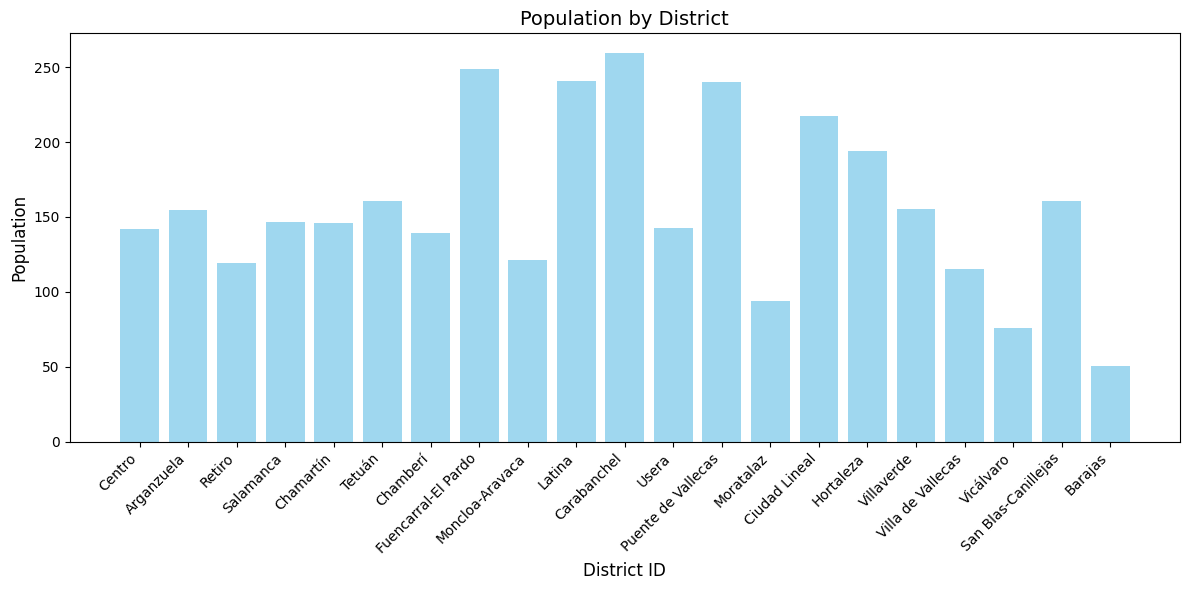

In [27]:
plt.figure(figsize=(12, 6))
plt.bar(distritos_and_pop["name_2"].astype(str), distritos_and_pop["Population"], color='skyblue', alpha=0.8)

# Add labels and title
plt.title("Population by District", fontsize=14)
plt.xlabel("District ID", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

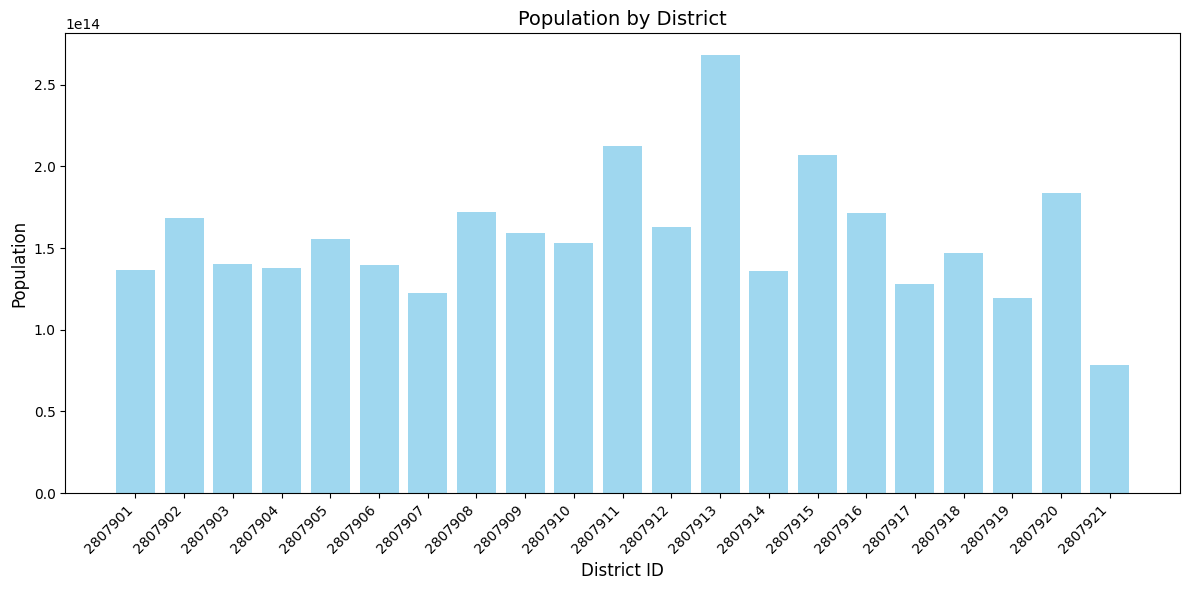

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(origin_trips["origen"].astype(str), origin_trips["total_viajes"], color='skyblue', alpha=0.8)

# Add labels and title
plt.title("Population by District", fontsize=14)
plt.xlabel("District ID", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

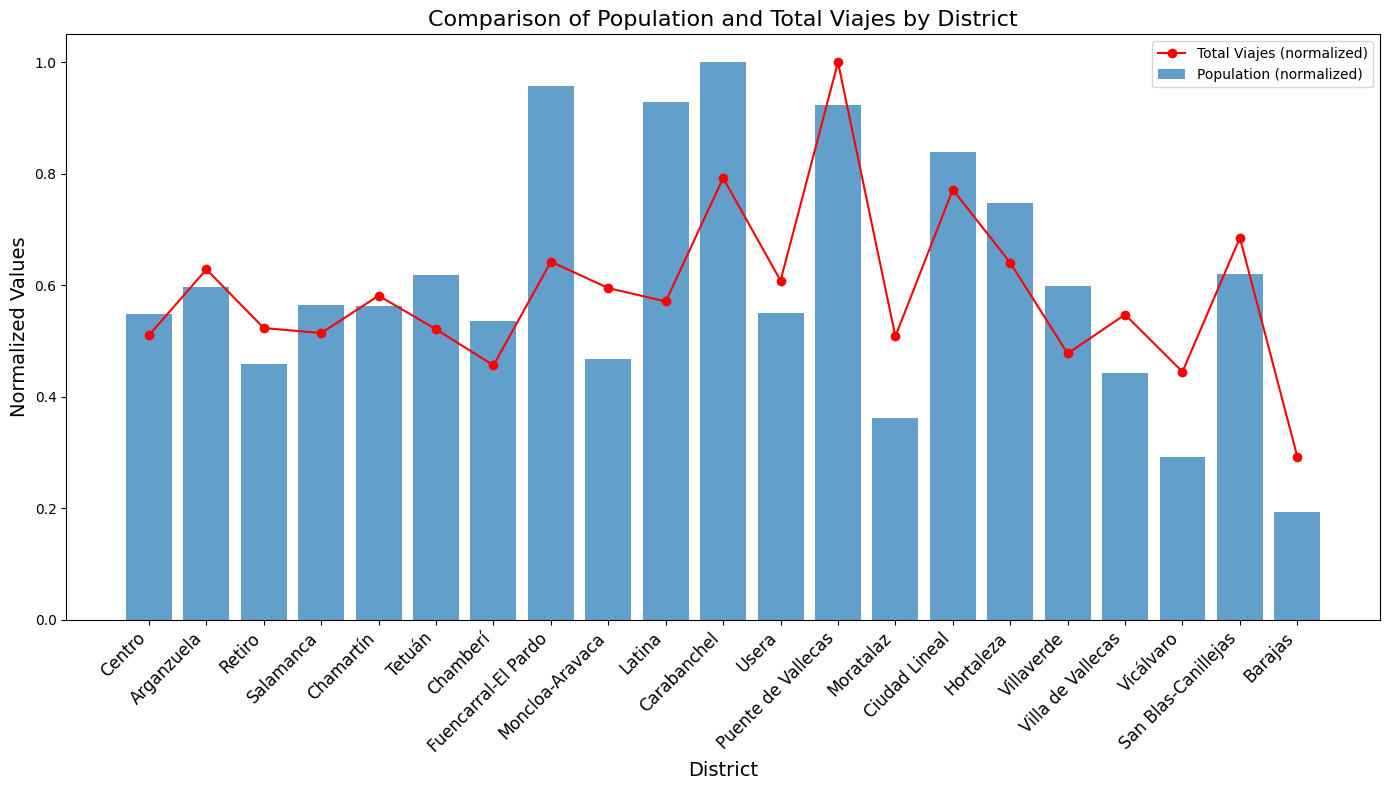

In [30]:
distritos_and_pop["ID"] = distritos_and_pop["ID"].astype(str)
origin_trips["origen"] = origin_trips["origen"].astype(str)

df_combined = pd.merge(distritos_and_pop, origin_trips, left_on="ID", right_on="origen")
df_combined.drop(columns=["ID", "origen"], inplace=True)

# Normalize columns for better comparison
df_combined["Population_normalized"] = df_combined["Population"] / df_combined["Population"].max()
df_combined["Viajes_normalized"] = df_combined["total_viajes"] / df_combined["total_viajes"].max()

# Plotting
plt.figure(figsize=(14, 8))

# Bar plot for Population
plt.bar(df_combined["name_2"], df_combined["Population_normalized"], label="Population (normalized)", alpha=0.7)

# Line plot for Total Viajes
plt.plot(df_combined["name_2"], df_combined["Viajes_normalized"], label="Total Viajes (normalized)", color="red", marker="o")

# Labels and title
plt.title("Comparison of Population and Total Viajes by District", fontsize=16)
plt.xlabel("District", fontsize=14)
plt.ylabel("Normalized Values", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()